## Assessing the Impact of Wales’ 20mph Default Speed Limit on Road Accident Rates



## Preparation

- [Github link](google.com) *[Optional]*

- Number of words: ***

- Runtime: *** hours (*Memory 10 GB, CPU Intel i7-10700 CPU @2.90GHz*)

- Coding environment: Visual Code Studio

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.
    - ......

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)



Road safety remains a critical public health concern globally, and the establishment and enforcement of speed limits are fundamental strategies employed to mitigate the risk and severity of road accidents (Wilmot and and Khanal, 1999). On 17th September 2023, the Welsh government introduced a default 20mph speed limit on restricted roads across Wales, which were previously subject to 30mph within built-up areas (gov.wales, 2024). This is the first national policy of its kind in the United Kingdom and aims to reduce injuries and fatalities from road collisions.  Evaluating the effectiveness of such a widespread policy change is crucial for understanding its impact on road safety outcomes and informing future policy decisions.

The analysis below will provide evidence-based insights into whether the intended objectives are being met and contribute to the broader understanding of effective road safety strategies.






In [49]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
from sklearn.linear_model import LinearRegression

from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp

## Research question

[[ go back to the top ]](#Table-of-contents)

What has been the causal impact of the implementation of the 20mph default speed limit in Wales on the rate of road accidents (fatal, serious, and slight) in the period following its enactment?


This question aims to determine whether the policy has led to a measurable change in the frequency of road accidents across different levels of severity since its introduction in September 2023. The focus is on establishing a causal link between the policy and any observed changes in accident rates, while also considering the magnitude of this effect across varying collision outcomes.


### Literature Review

##### The Scheme

Rolled out in September 2023 by the Labour-led Welsh government as a key road safety initiative, the scheme set 20mph as the default limit for built-up areas—defined by roads with lamp-posts spaced roughly 180 metres apart—covering around a third of all roads (gov.wales, 2024).

Initial studies suggest the policy has reduced road fatalities and insurance premiums (Walker, 2025). This research will build on these claims by comparing rates with selected control regions.


##### The Safe System approach to Road Safety

The implementation of the 20mph default speed limit in Wales is closely aligned with the principles of the "Safe System" approach to road safety, an internationally recognised framework that prioritises the elimination of fatal and serious injuries for all road users (FHWA, 2024).

The 20mph speed limit policy introduced by Wales directly addresses the safe speeds element of the 'Safe System' approach, as speed is a critical determinant of both the likelihood of a crash and the severity of injuries sustained. By reducing the default speed in built-up areas, the policy aims to lower impact forces in the event of a collision, thereby increasing the chances of survival and reducing the severity of injuries (Tefft, 2013).


##### Synthetic Control Methodology


This analysis adapts the code and methodology for synthetic control from Facure Alves' (2022) textbook.




## Data

[[ go back to the top ]](#Table-of-contents)


The primary source for official road collision statistics in Great Britain is the Department for Transport (DfT, 2025).

The DfT collects data through the STATS19 system, which requires police forces to record details of all personal injury collisions that occur on public roads and become known to them within 30 days (DfT, 2025).

The severity of injuries in road collisions is categorised into three levels: fatal (1), serious(2), and slight(3). A fatal collision is defined as one in which at least one person dies. A serious injury includes those for which a person is detained in hospital or seriously injured. A slight injury is defined as an injury that is minor, such as sprains, bruises, or cuts that are not considered severe.



| Variable                            | Type         | Description                                                             |Notes   |
|-------------------------------------|--------------|-------------------------------------------------------------------------|---|
| Collisions                | Numeric      | The number of collisions for each severity  |   |
| Population                        | Numeric      | Population for Each Region                                               |   |
| Region  | Categorical  | International Territorial Level 1 Region                                 |   |
| Collision Rate  | Numeric  | Collision Rate per 100,000 population for each severity                                    |   |
| Treatment | Dummy | 1 if region is Wales, 0 for Other |
| Post | Dummy | 1 if date is after intervention period 17/09/2023, 0 otherwise |
| Post-Treatment | Dummy | 1 if date is after 17/09/2023 and region is Wales, 0 otherwise |



### Road Collision Data

We start by loading in the road collision data for the years 2022, 2023, and provisional mid-year data for 2024. The total analysis timeframe spans from January 2022 to July 2024. A lookup file is containing geographical codes is also loaded for grouping data on regional scale later.


In [50]:
#reading in traffic collision data for 2022-2024

data2022 = pd.read_csv("data/dft-road-casualty-statistics-collision-2022.csv")
data2023 = pd.read_csv("data/dft-road-casualty-statistics-collision-2023.csv")
data2024 = pd.read_csv("data/dft-road-casualty-statistics-collision-provisional-mid-year-unvalidated-2024.csv")


#Lookup file which will be useful for merging regional data later
lookup = pd.read_csv("data/LAD20_LAU121_ITL321_ITL221_ITL121_UK_LU_v2.csv")
lookup = lookup[["LAD20CD","ITL121NM"]]


C:\Users\chris\AppData\Local\Temp\ipykernel_5104\3372749476.py:3: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data2022 = pd.read_csv("data/dft-road-casualty-statistics-collision-2022.csv")
C:\Users\chris\AppData\Local\Temp\ipykernel_5104\3372749476.py:4: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data2023 = pd.read_csv("data/dft-road-casualty-statistics-collision-2023.csv")
C:\Users\chris\AppData\Local\Temp\ipykernel_5104\3372749476.py:5: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data2024 = pd.read_csv("data/dft-road-casualty-statistics-collision-provisional-mid-year-unvalidated-2024.csv")


The 2024 collision data has slightly different formatting compared to the 2022 and 2023 datasets. So to ensure consistency across the datasets, the 'status' column is removed from 2024, and the column names are standardised.


In [51]:
data2023.shape


(104258, 37)

In [52]:
data2024.shape

(46707, 38)

In [53]:
set(data2023.columns) - set(data2024.columns)

{'accident_index',
 'accident_reference',
 'accident_severity',
 'accident_year',
 'did_police_officer_attend_scene_of_accident',
 'lsoa_of_accident_location'}

In [54]:
set(data2024.columns) - set(data2023.columns)

{'collision_index',
 'collision_reference',
 'collision_year',
 'did_police_officer_attend_scene_of_collision',
 'legacy_collision_severity',
 'lsoa_of_collision_location',
 'status'}

In [55]:
#removing status
data2024.drop("status", axis=1, inplace=True)

#renaming columns so that they are consistent across both datasets

rename_dict = {
    'collision_index': 'accident_index',
    'collision_reference': 'accident_reference',
    'legacy_collision_severity': 'accident_severity',
    'collision_year': 'accident_year',
    'did_police_officer_attend_scene_of_collision': 'did_police_officer_attend_scene_of_accident',
    'lsoa_of_collision_location': 'lsoa_of_accident_location'
}

# Rename columns in data2024
data2024 = data2024.rename(columns=rename_dict)

The collision data for all three years is then merged into a single DataFrame. The geographical lookup table is joined with the collision data using the local authority code to enable comparisons at a regional level.

In [56]:
#merging collision data together

data = pd.concat([data2023,data2024,data2022])


#adding lookup so I can compare regions
data = data.merge(lookup, left_on='local_authority_ons_district', right_on='LAD20CD')
data.drop('LAD20CD', axis=1, inplace=True)


data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')

data['month'] = data['date'].dt.strftime('%m/%Y')


data.head(5)

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision,ITL121NM,month
0,2023010419171,2023,10419171,525060.0,170416.0,-0.202878,51.418974,1,3,1,...,2,0,0,1,1,2,E01003383,-1,London,01/2023
1,2023010419183,2023,10419183,535463.0,198745.0,-0.042464,51.671155,1,3,3,...,1,0,0,1,1,2,E01001547,-1,London,01/2023
2,2023010419189,2023,10419189,508702.0,177696.0,-0.435789,51.487777,1,3,2,...,1,0,0,1,1,2,E01002448,-1,London,01/2023
3,2023010419191,2023,10419191,520341.0,190175.0,-0.263972,51.597575,1,3,2,...,1,0,0,1,1,2,E01000129,-1,London,01/2023
4,2023010419192,2023,10419192,527255.0,176963.0,-0.168976,51.477324,1,3,2,...,1,0,0,1,1,2,E01004583,-1,London,01/2023


The data is then transformed from an accident-level format to a daily count of each collision severity for each region to facilitate temporal analysis. 

In [57]:
daily_data = data.groupby(['ITL121NM','date','accident_severity']).size().reset_index(name="count")

daily_data.head()

,ITL121NM,date,accident_severity,count
0,East,2022-01-01,2,7
1,East,2022-01-01,3,7
2,East,2022-01-02,1,1
3,East,2022-01-02,2,4
4,East,2022-01-02,3,11


Additionally, as days with no collisions are currently not represented with a count of zero, this will be addressed to ensure accuray when calculating monthly averages later.

In [58]:
# Get the full date range
full_dates = pd.date_range(daily_data["date"].min(), daily_data["date"].max(), freq="D")

#Get unique values for region and severity
regions = daily_data["ITL121NM"].unique()
severities = [1, 2, 3]


#Create a full grid of all dates and all regions and all severities
full_grid = pd.MultiIndex.from_product(
    [full_dates, regions, severities],
    names=["date", "ITL121NM", "accident_severity"]
).to_frame(index=False)


# Merge with original data
daily_data = (
    full_grid
    .merge(daily_data, on=["date", "ITL121NM", "accident_severity"], how="left")
    .fillna({"count": 0})
)


daily_data.head()

,date,ITL121NM,accident_severity,count
0,2022-01-01,East,1,0.0
1,2022-01-01,East,2,7.0
2,2022-01-01,East,3,7.0
3,2022-01-01,East Midlands (England),1,0.0
4,2022-01-01,East Midlands (England),2,4.0


Population data for different regions is then loaded and cleaned to calculate accident rates per capita.
For this analysis it is assumed there is constant population (2023 data), so there is not a big jump of rates at the begginning of the year period. The region names in the population data are standardised to match the lookup table.

In [59]:
# Reading in population 2023 data
popdata = pd.read_csv("data/mye23tablesew.csv")

# Cleaning population
popdata["pop"] = popdata["All ages"].str.replace(",", "").astype(int)


#Subsetting to only include regions and Wales
regiondata = popdata[(popdata["Geography"] == "Region") | (popdata["Code"] == "W92000004")]

regiondata = regiondata[["Name", "pop"]]

regiondata


,Name,pop
2,NORTH EAST,2711380
16,NORTH WEST,7600126
55,YORKSHIRE AND THE HUMBER,5594125
73,EAST MIDLANDS,4991265
113,WEST MIDLANDS,6085687
148,EAST,6468665
199,LONDON,8945309
233,SOUTH EAST,9482507
304,SOUTH WEST,5811259
334,WALES,3164404


In [60]:
set(list(regiondata["Name"])) - set(list(lookup["ITL121NM"]))

{'EAST',
 'EAST MIDLANDS',
 'LONDON',
 'NORTH EAST',
 'NORTH WEST',
 'SOUTH EAST',
 'SOUTH WEST',
 'WALES',
 'WEST MIDLANDS',
 'YORKSHIRE AND THE HUMBER'}

In [61]:
set(list(lookup["ITL121NM"]))- set(list(regiondata["Name"])) 

{'East',
 'East Midlands (England)',
 'London',
 'North East (England)',
 'North West (England)',
 'Northern Ireland',
 'Scotland',
 'South East (England)',
 'South West (England)',
 'Wales',
 'West Midlands (England)',
 'Yorkshire and The Humber'}

In [62]:
rename_dict =  {
    "EAST": "East",
    "EAST MIDLANDS": "East Midlands (England)",
    "LONDON": "London",
    "NORTH EAST": "North East (England)",
    "NORTH WEST": "North West (England)",
    "SOUTH EAST": "South East (England)",
    "SOUTH WEST": "South West (England)",
    "WALES": "Wales",
    "WEST MIDLANDS": "West Midlands (England)",
    "YORKSHIRE AND THE HUMBER": "Yorkshire and The Humber"
}

# Apply the renaming
regiondata["Name"] = regiondata["Name"].replace(rename_dict)

The daily collision counts are then merged with the population data and used to calculate the daily accident rate per 100,000 people for each severity level and region.

In [63]:
daily_data = daily_data.merge(regiondata, left_on=["ITL121NM"], right_on=["Name"])

#creating accident rate (per 100,000) for each day and severity group
daily_data["accident_rate"] = (daily_data["count"] / daily_data["pop"])*100000
daily_data["accident_rate"] = daily_data["accident_rate"].astype(float)
daily_data['month'] = daily_data['date'].dt.strftime('%m/%Y')
daily_data["month"] = pd.to_datetime(daily_data["month"], format="%m/%Y")  



Finally, dummy variables are created for the Difference-in-Differences and Synthetic Control analyses.


In [64]:
daily_data['post']=np.where(daily_data['date']>='17/09/2023',1,0)
daily_data['treatment']=np.where(daily_data['ITL121NM']=='Wales',1,0)
daily_data['post_treatment']=daily_data['post']*daily_data['treatment']

In [65]:
daily_data.head()

,date,ITL121NM,accident_severity,count,Name,pop,accident_rate,month,post,treatment,post_treatment
0,2022-01-01,East,1,0.0,East,6468665,0.000000,2022-01-01,0,0,0
1,2022-01-01,East,2,7.0,East,6468665,0.108214,2022-01-01,0,0,0
2,2022-01-01,East,3,7.0,East,6468665,0.108214,2022-01-01,0,0,0
3,2022-01-01,East Midlands (England),1,0.0,East Midlands (England),4991265,0.000000,2022-01-01,0,0,0
4,2022-01-01,East Midlands (England),2,4.0,East Midlands (England),4991265,0.080140,2022-01-01,0,0,0


The data is now prepared for the subsequent analysis using Synthetic Control and Difference-in-Differences methods.

## Methodology

[[ go back to the top ]](#Table-of-contents)



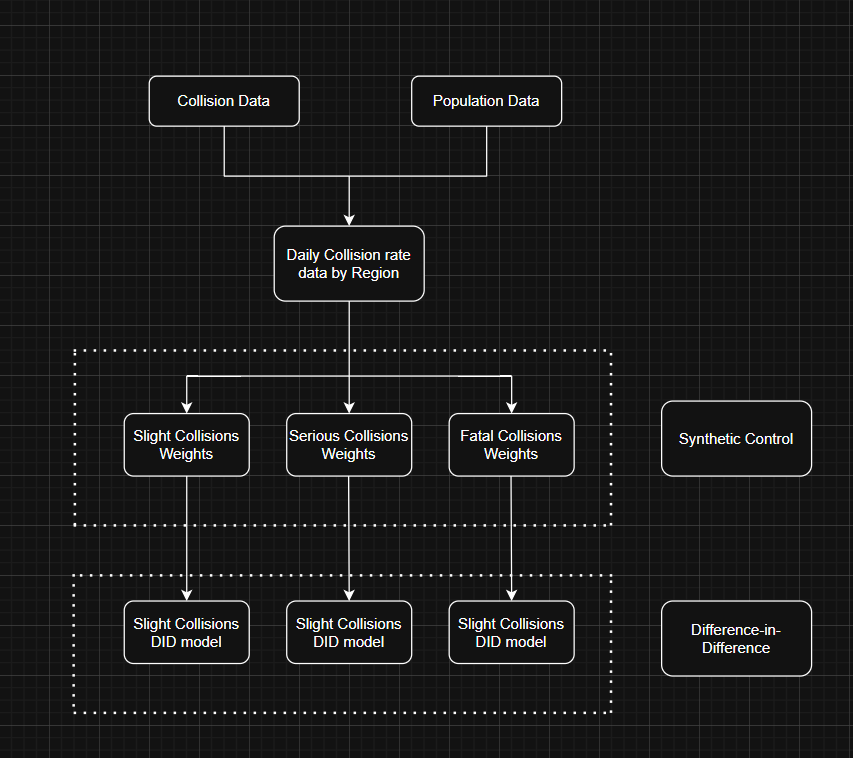


To assess the impact of Wales’ 20mph speed limit policy on road collision rates, this report will primarily employ Synthetic Control and Difference-In-Difference Analysis. 


#### Synthetic Control

Synthetic Control Analysis will construct a counterfactual for Wales' collision rates by weighting data from a pool of comparable UK regions that did not implement similar policies. This method will identify weights that best replicate Wales' pre-intervention collision trends. The treatment effect will be estimated by comparing Wales' post-intervention collision rates to the synthetic control's predicted rates.

The mathematical representation of the synthetic control estimator for the outcome variable $Y$ of the treated unit (Wales, denoted by index 1) at time $t$ is given by:

$$
\hat{Y}_{1t}^{N} = \sum_{j=2}^{J+1} W_j Y_{jt}
$$

where $W_j$ are the weights assigned to each control region $(Y_{jt})$, determined by minimising the difference in pre-intervention trends. The treatment effect is estimated by comparing Wales' post-intervention collision rates to $\hat{Y}_{1t}^{N}$. Placebo tests will assess the statistical significance of this effect.


#### Difference in Difference

Difference-in-Differences (DID) Analysis will provide a more focused assessment using specifically identified control region. An Ordinary Least Squares (OLS) regression model will estimate the causal effect and statistical significance:


$$Y_{it} = \beta_0 + \beta_1 Treatment_i + \beta_2 Post_t + \beta_3 (Treatment_i \times Post_t) + \varepsilon_{it}$$


where $\beta_3$, the coefficient of the interaction term $(Treatment_i \times Post_t)$, quantifies the policy's impact on collision rates $(Y_{it})$ for region $i$ at time $t$.

This combined methodology will provide a visual and statistical evaluation of the 20mph speed limit policy's effect on road collision rates in Wales.



## Descriptive and Visual Analysis

Firstly we will look at the accident Severity rates by region before the intervention period to give idea on the similarity between Wales and the other regions

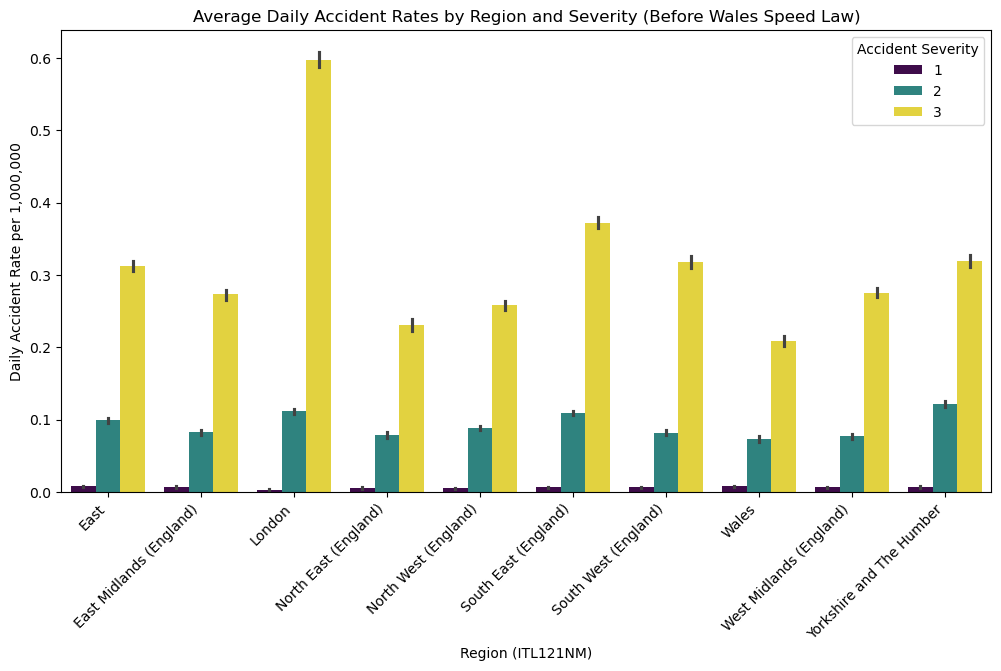

In [66]:
plt.figure(figsize=(12, 6))
sns.barplot(data=daily_data[daily_data['post']==0], x='ITL121NM', y='accident_rate', hue='accident_severity', palette='viridis')



plt.xticks(rotation=45, ha='right')
plt.xlabel('Region (ITL121NM)')
plt.ylabel('Daily Accident Rate per 1,000,000')
plt.title('Average Daily Accident Rates by Region and Severity (Before Wales Speed Law)')
plt.legend(title='Accident Severity')


This plot clearly shows that all region have comparable rates except for London, likely as it is very urban compared to other regions.  Therefore, it will be removed from future analysis. Visually it appears that the North-East most closely matches per intervention rates to Wales.

In [67]:
daily_data = daily_data[daily_data["ITL121NM"] != "London"]

Next we will look at accident rates Wales vs the other regions over time, to explore how Wales compares to the rest of the UK and if there is a clear trend change after the intervention period.

Text(0.5, 1.0, 'Gap in Slight Collision Rate')

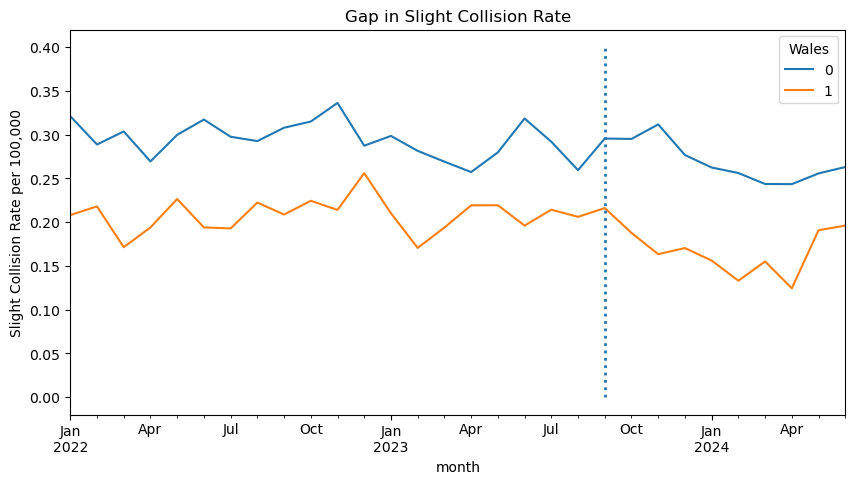

In [68]:
x_date = pd.to_datetime('17/09/2023', dayfirst=True)
slight_data = daily_data[daily_data["accident_severity"]==3]
serious_data = daily_data[daily_data["accident_severity"]==2]
fatal_data = daily_data[daily_data["accident_severity"]==1]

ax = plt.subplot(1,1,1)

(slight_data
    .assign(Wales = np.where(slight_data["treatment"], 1, 0))
    .groupby(["month", "Wales"])["accident_rate"]
    .mean()
    .reset_index()
    .pivot(index="month", columns="Wales", values="accident_rate")
    .plot(ax=ax, figsize=(10,5))
)
plt.vlines(x=x_date, ymax=0.4, ymin=0.000, linestyles=":",lw=2,label ="Wales Restricted Road Speed")
plt.ylabel("Slight Collision Rate per 100,000")
plt.title("Gap in Slight Collision Rate")


The graph shows that are less slight collisions per capita in Wales than the national average. It also appears that the slight collision rate decreased after the new speed limit policy was introduced.

Text(0.5, 1.0, 'Gap in Serious Collision Rate')

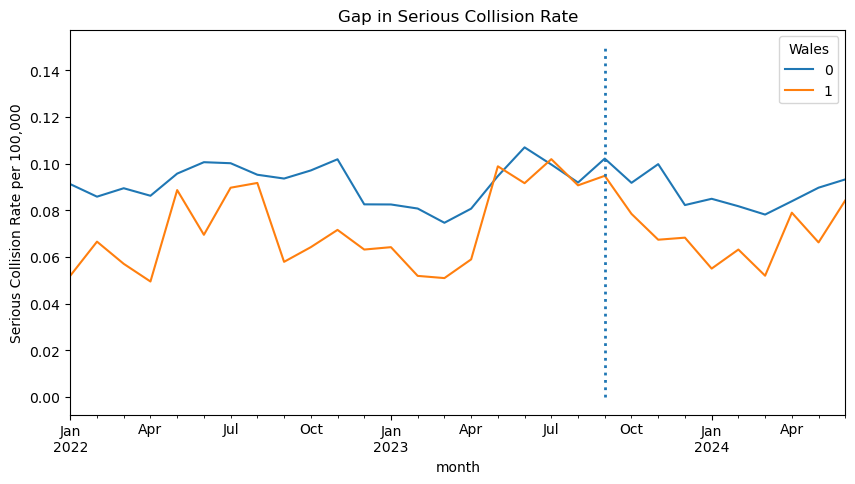

In [69]:
ax = plt.subplot(1,1,1)

(serious_data
    .assign(Wales = np.where(serious_data["treatment"], 1, 0))
    .groupby(["month", "Wales"])["accident_rate"]
    .mean()
    .reset_index()
    .pivot(index="month", columns="Wales", values="accident_rate")
    .plot(ax=ax, figsize=(10,5))
)
plt.vlines(x=x_date, ymax=0.15, ymin=0.000, linestyles=":",lw=2,label ="Wales Restricted Road Speed")
plt.ylabel("Serious Collision Rate per 100,000")
plt.title("Gap in Serious Collision Rate")


Serious collision rate in Wales are similar to other regions in the UK. There is also a visible decrease in the serious collision rate after the policy was enacted.

Text(0.5, 1.0, 'Gap in Fatal Collision Rate')

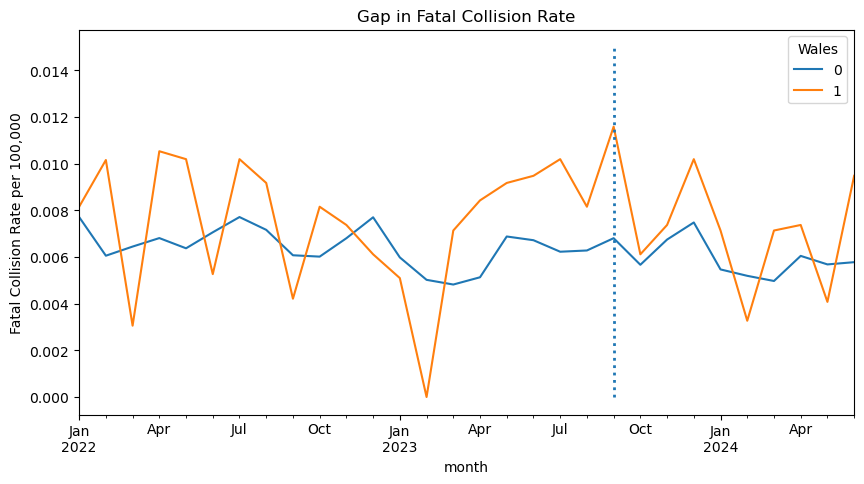

In [70]:
ax = plt.subplot(1,1,1)

(fatal_data
    .assign(Wales = np.where(fatal_data["treatment"], 1, 0))
    .groupby(["month", "Wales"])["accident_rate"]
    .mean()
    .reset_index()
    .pivot_table(index="month", columns="Wales", values="accident_rate", fill_value=0)
    .plot(ax=ax, figsize=(10,5))
)
plt.vlines(x=x_date, ymax=0.015, ymin=0.000, linestyles=":",lw=2,label ="Wales Restricted Road Speed")
plt.ylabel("Fatal Collision Rate per 100,000")
plt.title("Gap in Fatal Collision Rate")

Fatal crash rates are similar but slightly higher in Wales than the national Average. There is no visible decrease in the rates after the policy was enacted and is very sporadic liekly due to the rare occurances of fatal collisions.

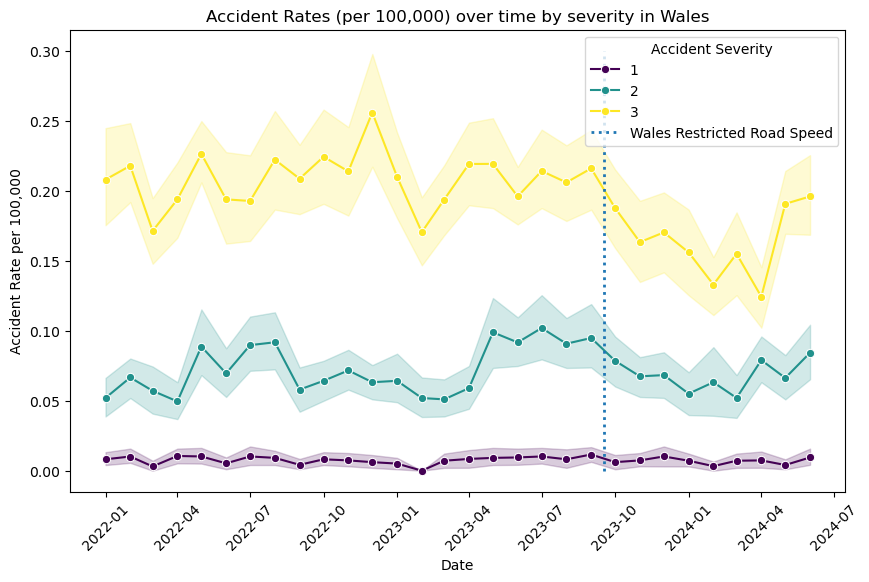

In [71]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily_data[daily_data["ITL121NM"]=="Wales"], x='month', y='accident_rate', hue='accident_severity', marker="o", palette='viridis')
plt.vlines(x=x_date, ymax=0.3, ymin=0.000, linestyles=":",lw=2,label ="Wales Restricted Road Speed")
plt.xlabel('Date')
plt.ylabel('Accident Rate per 100,000')
plt.title('Accident Rates (per 100,000) over time by severity in Wales')
plt.legend(title='Accident Severity')
plt.xticks(rotation=45)
plt.show()

Whilst it does appear there is a decrease in rates for slight and serious collisions after the intervention, we need to be able to prove that this change is causally related.

### Synthetic Control


In [ ]:
#This function defines how to measure how well the synthetic Wales 
# matches the real Wales before the event. It calculates the average 
# difference between them, where the smaller this difference, the better the fit.

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

In [ ]:
# An algorithm (fmin_slsqp) is applied to find the best set of weights to assign to each of the 
# other regions. The goal is to find the weights that make the synthetic Wales match the real 
# Wales as closely as possible by minimising the "goodness of fit".

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1, # ensures the weights add up to 1. 
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [74]:
# The data for Wales and the other regions from before the intervention is then used to find the 
# best weights to create a synthetic control for Wales. The output shows the weights assigned 
# to each of the other regions. 


slight_pre = (slight_data[slight_data["post"]==0]
            .pivot_table(index='ITL121NM', 
                         columns = "month", 
                         values = "accident_rate",
                         aggfunc="mean")
            .T)

y = slight_pre["Wales"].values
X = slight_pre.drop(columns="Wales").values

wales_slight_weights = get_w(X, y)
print("Sum:", wales_slight_weights.sum())
np.round(wales_slight_weights, 4)

Sum: 1.0000000000000002


array([0., 0., 1., 0., 0., 0., 0., 0.])

In this case for slight collisions, the North East got a weight of 1, and all others got 0, meaning the synthetic control for Wales is just the North East.

In [ ]:
#The calculated weights are then used to create the data for the synthetic Wales after the intervention period.

wales_slight_synth = (slight_data[slight_data['treatment']==0]
                  .pivot_table(index='month', 
                               columns="ITL121NM",
                               values ="accident_rate",
                               aggfunc = "mean")
                  .values.dot(wales_slight_weights))

## Results and discussion

[[ go back to the top ]](#Table-of-contents)


The synthetic Wales can now be plotted after intervention period to predict what collision rates would have looked like if the intervention never took place.

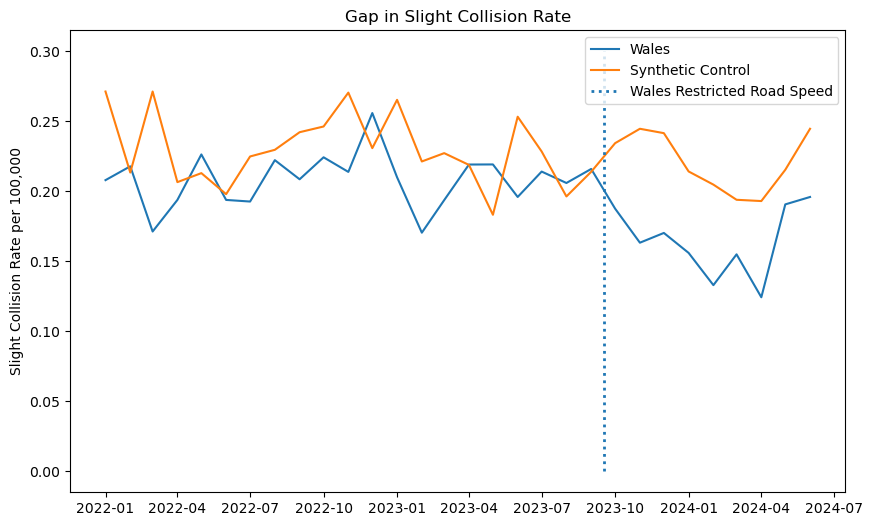

In [76]:
wales_slight = (
    slight_data[slight_data["treatment"] == 1]
    .groupby("month")["accident_rate"]
    .mean()
)

plt.figure(figsize=(10,6))
plt.plot(wales_slight.index, wales_slight.values, label="Wales")
plt.plot(wales_slight.index, wales_slight_synth, label="Synthetic Control")
plt.vlines(x=x_date, ymax=0.3, ymin=0.000, linestyles=":",lw=2, label ="Wales Restricted Road Speed")
plt.title("Gap in Slight Collision Rate")
plt.ylabel("Slight Collision Rate per 100,000")
plt.legend();

Before the Speed Limit policy was implemented, the Synthetic Control generally replicates the trajectory of slight collision rates in Wales. There are some fluctuations and periods where they diverge slightly, but the overall trend is similar.

After the policy was implemented, there is a noticeable divergence between the two lines. Wales' actual slight collision rate appears to decrease and stays consistently below the synthetic control, suggesting that the policy may have led to a reduction in slight collision rates in Wales. 

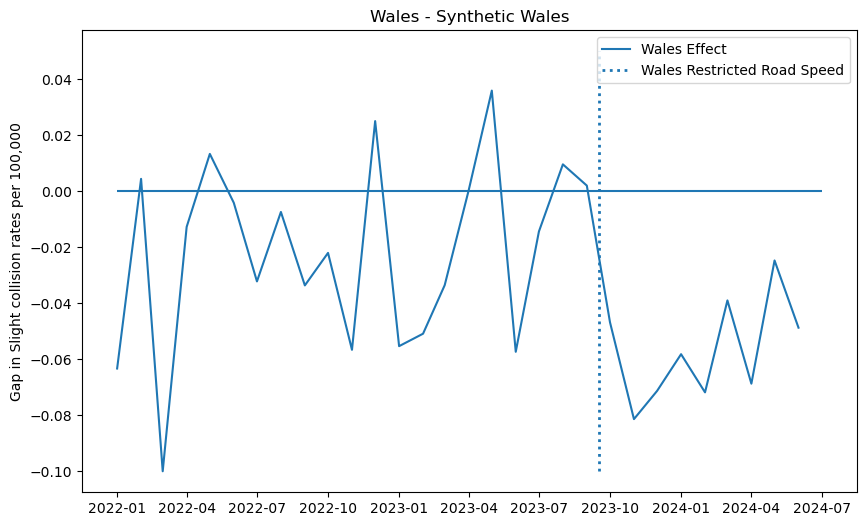

In [77]:
xmin = pd.to_datetime("2022-01")
xmax = pd.to_datetime("2024-07")

plt.figure(figsize=(10,6))
plt.plot(wales_slight.index, wales_slight.values - wales_slight_synth, label = "Wales Effect")
plt.vlines(x=x_date, ymax=0.05, ymin=-0.1, linestyles=":",lw=2, label ="Wales Restricted Road Speed")
plt.hlines(y=0, xmin=xmin, xmax=xmax)
plt.title("Wales - Synthetic Wales")
plt.ylabel("Gap in Slight collision rates per 100,000")
plt.legend();

In [78]:
serious_pre = (serious_data[serious_data["post"]==0]
            .pivot_table(index='ITL121NM', 
                         columns = "month", 
                         values = "accident_rate",
                         aggfunc="mean")
            .T)


y = serious_pre["Wales"].values
X = serious_pre.drop(columns="Wales").values

wales_serious_weights = get_w(X, y)
print("Sum:", wales_serious_weights.sum())
np.round(wales_serious_weights, 4)


Sum: 1.0000000000000002


array([0.    , 0.0629, 0.    , 0.    , 0.    , 0.    , 0.9371, 0.    ])

The outputs here shows that, the East Midlands got a weight of 0.0629, and West Midlands got a weight of 0.9371, meaning the synthetic control for Wales is the weighted average of those regions.

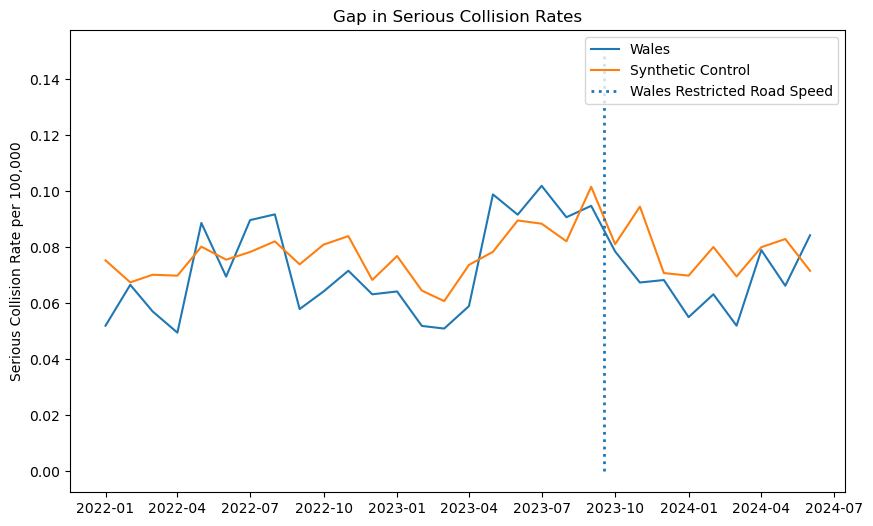

In [79]:
wales_serious_synth = (serious_data[serious_data['treatment']==0]
                  .pivot_table(index='month', 
                               columns="ITL121NM",
                               values ="accident_rate",
                               aggfunc = "mean")
                  .values.dot(wales_serious_weights))


wales_serious = (
    serious_data[serious_data["treatment"] == 1]
    .groupby("month")["accident_rate"]
    .mean()
)

plt.figure(figsize=(10,6))
plt.plot(wales_serious.index, wales_serious.values, label="Wales")
plt.plot(wales_serious.index, wales_serious_synth, label="Synthetic Control")
plt.vlines(x=x_date, ymax=0.15, ymin=0.000, linestyles=":",lw=2, label ="Wales Restricted Road Speed")
plt.ylabel("Serious Collision Rate per 100,000")
plt.title("Gap in Serious Collision Rates")
plt.legend();

Similar to the previous graph for slight collisions, the Synthetic Control  generally tracks the trend of serious collision rates in Wales before the implementation of the restricted road speed policy. This suggests a reasonable fit for the pre-intervention period.

The visual evidence here is less conclusive regarding the impact of the policy on serious collision rates, as the Wales line seems to fluctuate closely to or even slightly above the Synthetic Control line.

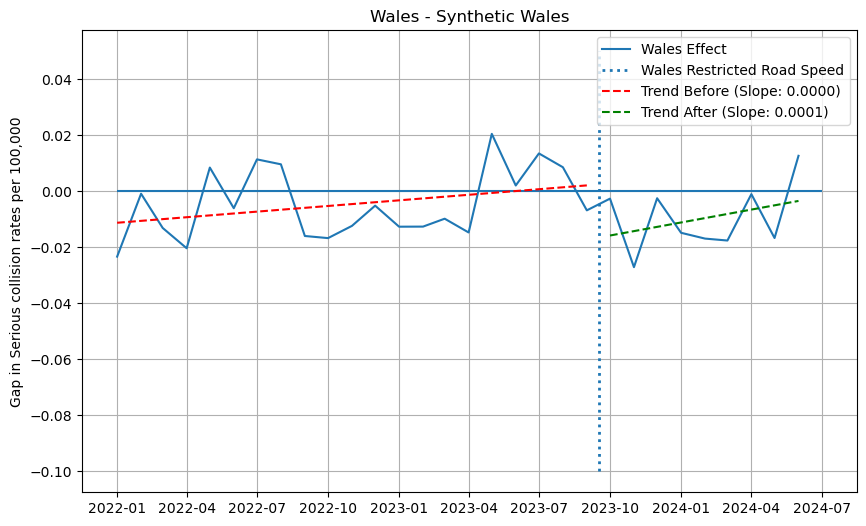

In [93]:
plt.figure(figsize=(10,6))
plt.plot(wales_serious.index, wales_serious.values - wales_serious_synth, label = "Wales Effect")
plt.vlines(x=x_date, ymax=0.05, ymin=-0.1, linestyles=":",lw=2, label ="Wales Restricted Road Speed")
plt.hlines(y=0, xmin=xmin, xmax=xmax)
plt.title("Wales - Synthetic Wales")
plt.ylabel("Gap in Serious collision rates per 100,000")
plt.legend();


In [81]:
fatal_pre = (fatal_data[fatal_data["post"]==0]
            .pivot_table(index='ITL121NM', 
                         columns = "month", 
                         values = "accident_rate",
                         aggfunc="mean")
            .T)

y = fatal_pre["Wales"].values
X = fatal_pre.drop(columns="Wales").values

wales_fatal_weights = get_w(X, y)
print("Sum:", wales_fatal_weights.sum())
np.round(wales_fatal_weights, 4)


Sum: 1.0


array([0.2891, 0.2406, 0.0256, 0.    , 0.1136, 0.0311, 0.2999, 0.    ])

Fatal collisions Synthetic control Weights

- East: 0.2891
- East Midlands: 0.2406
- North East: 0.0256
- South East: 0.1136
- South West: 0.0311
- West Midlands: 0.2999

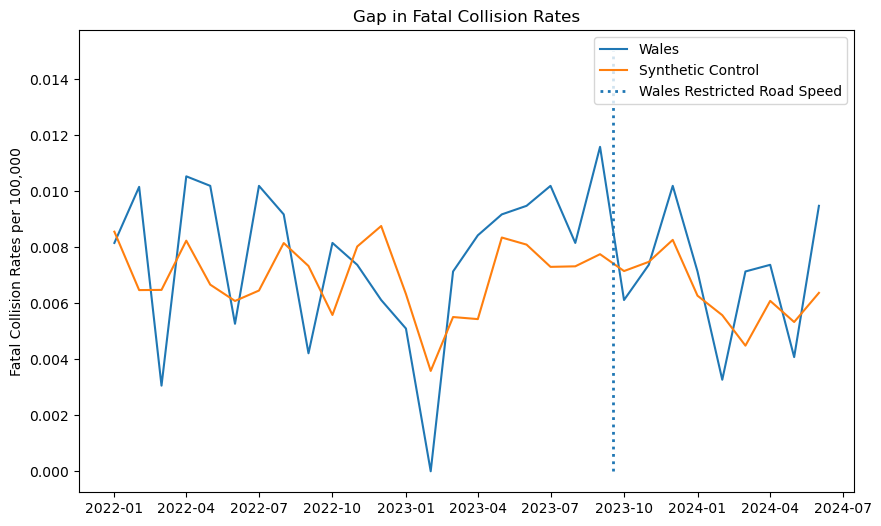

In [82]:
wales_fatal_synth = (fatal_data[fatal_data['treatment']==0]
                  .pivot_table(index='month', 
                               columns="ITL121NM",
                               values ="accident_rate",
                               aggfunc = "mean")
                  .values.dot(wales_fatal_weights))


wales_fatal = (
    fatal_data[fatal_data["treatment"] == 1]
    .groupby("month")["accident_rate"]
    .mean()
)

plt.figure(figsize=(10,6))
plt.plot(wales_fatal.index, wales_fatal.values, label="Wales")
plt.plot(wales_fatal.index, wales_fatal_synth, label="Synthetic Control")
plt.vlines(x=x_date, ymax=0.015, ymin=0.000, linestyles=":",lw=2, label ="Wales Restricted Road Speed")
plt.title("Gap in Fatal Collision Rates")
plt.ylabel("Fatal Collision Rates per 100,000")
plt.legend();

Before the policy change, the Synthetic Control  appears to track the general movement of fatal collision rates in Wales. However, there seems to be more volatility and larger deviations between the two lines compared to the pre-intervention fit observed for slight and serious collision.

The post intervention trend is quite mixed and doesn't show a clear or immediate impact. The rarity of fatal accidents makes the data more volatile and harder to detect the impact of an intervention using a Synthetic Control approach over a relatively short period.

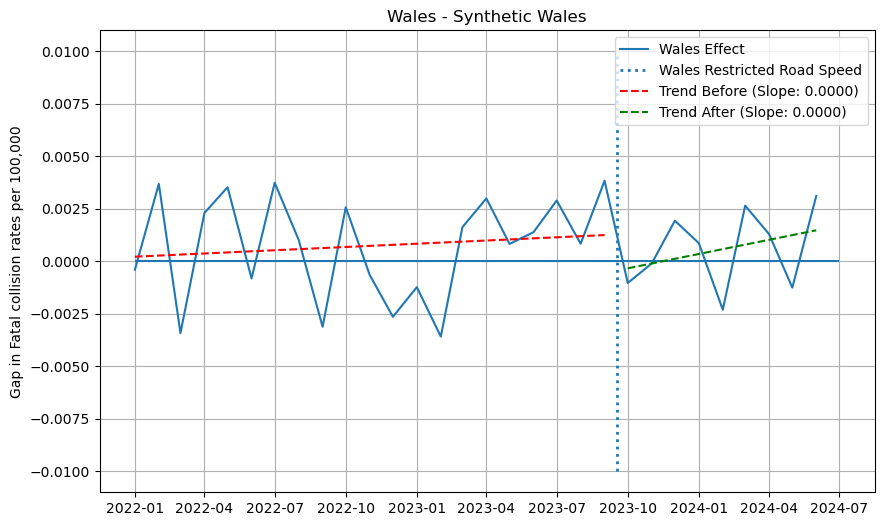

In [92]:
plt.figure(figsize=(10,6))
plt.plot(wales_fatal.index, wales_fatal.values - wales_fatal_synth, label = "Wales Effect")
plt.vlines(x=x_date, ymax=0.01, ymin=-0.01, linestyles=":",lw=2, label ="Wales Restricted Road Speed")
plt.hlines(y=0, xmin=xmin, xmax=xmax)
plt.title("Wales - Synthetic Wales")
plt.ylabel("Gap in Fatal collision rates per 100,000")
plt.legend();


Now, we want to know if these differences we see are statistically significant and not just occuring by random chance. 

which leads onto the Difference-in-Differences (DID) analysis, comparing Wales to the identified regions that are similar in terms of collision trends before the policy for each severity.



#### Difference in Difference Analysis

In [84]:
selected_regions = ["Wales", "North East (England)"]

did_data = daily_data[daily_data['ITL121NM'].isin(selected_regions)]

did_slight = did_data[did_data["accident_severity"] == 3]


In [85]:
did_slight_model = ols('accident_rate ~ post + treatment + post_treatment', did_slight).fit()

print(did_slight_model.summary())

                            OLS Regression Results                            
Dep. Variable:          accident_rate   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     32.36
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           2.25e-20
Time:                        15:12:46   Log-Likelihood:                 1717.7
No. Observations:                1824   AIC:                            -3427.
Df Residuals:                    1820   BIC:                            -3405.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2307      0.004     61.

Comparing Wales to the North East, the DID model reveals a statistically significant and negative post-treatment coefficient of -0.0321 daily slight collisions per 100,000 population. This indicates that the 20mph policy in Wales was associated with a statistically significant reduction in slight collision rates beyond the trend observed in the North East. Translating this to the Welsh population, this equates to an estimated reduction of approximately one fewer slight collision per day, or roughly 372 fewer slight collisions annually.

As the serious synthetic control was weighted 93.7% towards the West Midlands, we will use that for the corresponding DID model

In [86]:
selected_regions = ["Wales", "West Midlands (England)"]

did_data = daily_data[daily_data['ITL121NM'].isin(selected_regions)]

did_serious = did_data[did_data["accident_severity"] == 2]

In [87]:
did_serious_model = ols('accident_rate ~ post + treatment + post_treatment', did_serious).fit()

print(did_serious_model.summary())

                            OLS Regression Results                            
Dep. Variable:          accident_rate   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.489
Date:                Sun, 20 Apr 2025   Prob (F-statistic):             0.0152
Time:                        15:12:46   Log-Likelihood:                 3027.1
No. Observations:                1824   AIC:                            -6046.
Df Residuals:                    1820   BIC:                            -6024.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0767      0.002     41.

The DID analysis comparing Wales to the West Midlands produces a post-treatment coefficient of -0.0072 daily serious collisions per 100,000 population, suggesting a decrease. However, this coefficient was not statistically significant. Therefore, while there appears to be a reduction in serious collisions, we cannot confidently attribute this reduction to the 20mph policy, as it could be due to other unobserved factors or random variation. This translates to a non-significant estimated reduction of approximately 83 serious collisions per year.

For The fatal DID model, we will use the four highest weighted synthetic weights, the East, East Midlands, West Midlands and the South East.

In [96]:
selected_regions = ["Wales", "East", "East Midlands (England)", "West Midlands (England)", "South East (England)"]

did_data = daily_data[daily_data['ITL121NM'].isin(selected_regions)]

did_fatal = did_data[did_data["accident_severity"] == 1]

In [97]:
did_fatal_model = ols('accident_rate ~ post + treatment + post_treatment', did_fatal).fit()

print(did_fatal_model.summary())

                            OLS Regression Results                            
Dep. Variable:          accident_rate   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.692
Date:                Sun, 20 Apr 2025   Prob (F-statistic):             0.0446
Time:                        15:44:04   Log-Likelihood:                 13925.
No. Observations:                4560   AIC:                        -2.784e+04
Df Residuals:                    4556   BIC:                        -2.782e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0069      0.000     30.

The DID model for fatal collisions, using a composite control group of the East, East Midlands, South East, and West Midlands, showed a positive post-treatment coefficient of 0.0005 daily fatal collisions per 100,000 population, suggesting a potential increase. However, this coefficient was also statistically insignificant. Consequently, the analysis provides no statistically significant evidence of an impact of the 20mph policy on fatal collision rates. This non-significant increase equates to a very small estimated change of around 5-6 more deaths per year, which cannot be reliably attributed to the policy.



## Conclusion

[[ go back to the top ]](#Table-of-contents)

The findings of this study suggest a differentiated impact of the 20mph default speed limit policy on road collision severities in Wales. The statistically significant reduction in slight collisions provides compelling evidence that the policy has been effective in reducing less severe road incidents. This could be attributed to lower speeds providing drivers with more time to react and reducing the severity of impacts when collisions do occur.

The inconclusive evidence regarding serious collisions suggests that the relationship between the 20mph policy and serious injuries is more complex. Serious collisions may be influenced by a broader range of factors beyond average speed, such as driver behavior in specific high-risk situations, road infrastructure, and vehicle safety features. The effect of the 20mph policy on these more severe incidents might also take longer to come into effect or be of a smaller magnitude that is harder to detect with the current data.

The lack of a statistically significant impact on fatal collisions is likely due to the rarity and more stochastic nature of these events. Detecting the effect of a policy intervention on such low-frequency outcomes requires longer time series data and potentially different analytical approaches. It is also possible that factors beyond general speed limits play a more dominant role in fatal accidents.

In conclusion, this analysis provides evidence of a positive impact of the 20mph default speed limit policy on reducing slight road collisions in Wales. However, further research with longer post-intervention data and exploration of other contributing factors is needed to draw more definitive conclusions regarding the impact on serious and fatal collisions.




limitations and what next:


This is a macro analysis - the impacts wont be spatially consistent so further analysis could explore Wales on a finer scale than the entire country.

an exploration into specific factors - e.g., elderly population, cars on the road, road types. 
 

## References

[[ go back to the top ]](#Table-of-contents)

- DfT (2025) Road Safety Data. Available at: https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-accidents-safety-data (Accessed: 20 April 2025).

- Facure Alves, M. (2022) Causal Inference for The Brave and True — Causal Inference for the Brave and True - 15 Synthetic Control . Available at: https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html (Accessed: 20 April 2025).
- FHWA (2024) Zero Deaths and Safe System | FHWA. Available at: https://highways.dot.gov/safety/zero-deaths (Accessed: 20 April 2025).

- gov.wales (2024) Introducing default 20mph speed limits | GOV.WALES. Available at: https://www.gov.wales/introducing-default-20mph-speed-limits (Accessed: 16 April 2025).

- Tefft, B.C. (2013) ‘Impact speed and a pedestrian’s risk of severe injury or death’, Accident Analysis & Prevention, 50, pp. 871–878. Available at: https://doi.org/10.1016/j.aap.2012.07.022.

- Walker, P. (2025) ‘Wales’s 20mph speed limit has cut road deaths. Why is there still even a debate?’, The Guardian, 22 March. Available at: https://www.theguardian.com/world/2025/mar/22/wales-20mph-speed-limit-cut-road-deaths-why-debate (Accessed: 20 April 2025).


- Wilmot, C.G. and and Khanal, M. (1999) ‘Effect of Speed limits on speed and safety: A review’, Transport Reviews, 19(4), pp. 315–329. Available at: https://doi.org/10.1080/014416499295420.
